In [1]:
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

%matplotlib inline

In [2]:
def get_df(athlete_id: int):
    athlete_url = f'https://www.parkrun.ru/results/athleteeventresultshistory/?athleteNumber={athlete_id}&eventNumber=0'
    page_all_results = requests.get(athlete_url, headers={'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:86.0) Gecko/20100101 Firefox/86.0'})
    df = pd.read_html(page_all_results.text)[2]
    df['Год'] = pd.to_datetime(df['Дата parkrun'], dayfirst=True).dt.year
    df['Месяц'] = pd.to_datetime(df['Дата parkrun'], dayfirst=True).dt.month_name(locale='ru_RU.UTF-8').str.slice(stop=3)
    return df

In [3]:
# Personal parkrun ID
my_id = 2664123

In [4]:
df = get_df(my_id)
df

,Паркран,Дата parkrun,Номер пробежки,Место,Время,Рейтинг,ЛР?,Год,Месяц
0,Kuzminki,22/05/2021,211,11,19:56,67.47%,NaN,2021,Мая
1,Kuzminki,15/05/2021,210,24,22:15,60.45%,NaN,2021,Мая
2,Kuzminki,01/05/2021,208,4,19:47,67.99%,NaN,2021,Мая
3,Kuzminki,17/04/2021,206,10,19:50,67.82%,NaN,2021,Апр
4,Kuzminki,10/04/2021,205,10,20:59,64.10%,NaN,2021,Апр
...,...,...,...,...,...,...,...,...,...
65,Kuzminki,08/10/2016,17,16,21:55,59.85%,NaN,2016,Окт
66,Kuzminki,01/10/2016,16,26,21:04,62.26%,NaN,2016,Окт
67,Kuzminki,17/09/2016,14,13,22:24,58.56%,NaN,2016,Сен
68,Kuzminki,27/08/2016,11,9,20:54,62.76%,ЛР,2016,Авг


In [5]:
months = ['Янв','Фев','Мар','Апр','Мая','Июн','Июл','Авг','Сен','Окт','Ноя','Дек']

In [6]:
rundata_long = df.pivot_table(index='Месяц', columns='Год', values='Время', aggfunc=len, fill_value=0).astype(int)

for month in months:
    if month not in rundata_long.index.values:
        rundata_long.loc[month] = 0
# sort chronological
rundata_long = rundata_long.reindex(months)
maxruns = rundata_long.max().max()

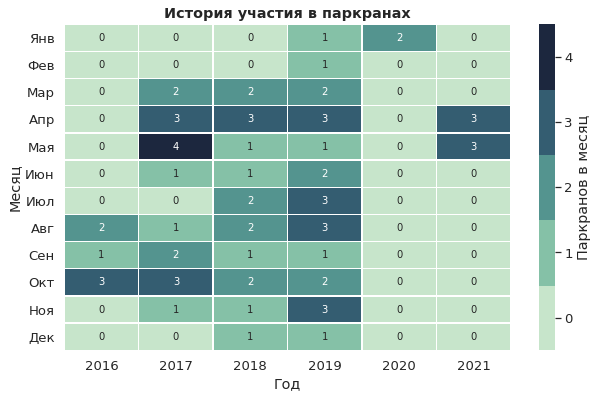

CPU times: user 1.27 s, sys: 1.47 s, total: 2.74 s
Wall time: 4.05 s


In [7]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))

# Plot number of runs by month/year
cmap = sns.cubehelix_palette(rot=-.4, n_colors=maxruns+1)

ticks=np.arange(0,maxruns+1)
boundaries = np.arange(-0.5,maxruns+1.5 )

ax = sns.heatmap(rundata_long, annot=True, linewidths=0.4, cmap=cmap,
                 cbar_kws={"ticks":ticks, "boundaries":boundaries, 'label': 'Паркранов в месяц'})
ax.set_title("История участия в паркранах", fontweight='bold')

plt.show()

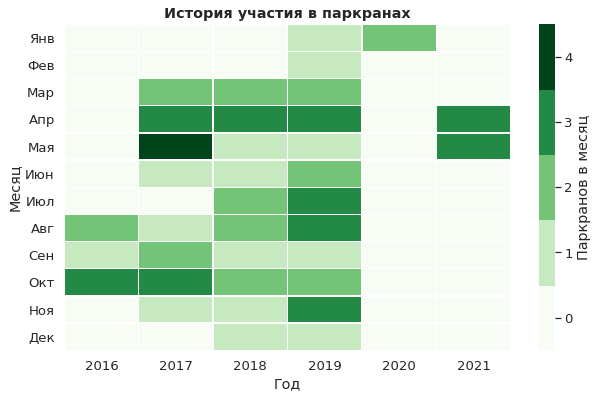

CPU times: user 489 ms, sys: 290 ms, total: 779 ms
Wall time: 862 ms


In [8]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))

ticks=np.arange(0, maxruns+1)
boundaries = np.arange(-0.5, maxruns+1.5)

sns.heatmap(rundata_long, linewidths=0.4, cmap='Greens',
            cbar_kws={"ticks":ticks, "boundaries":boundaries, 'label': 'Паркранов в месяц'})
ax.set_title("История участия в паркранах", fontweight='bold')

plt.show()

In [9]:
# Extract times in minutes
df['t_m']=df['Время'].transform(lambda time: sum(x * int(t) for x, t in zip([1/60, 1, 60], time.split(':')[::-1])))

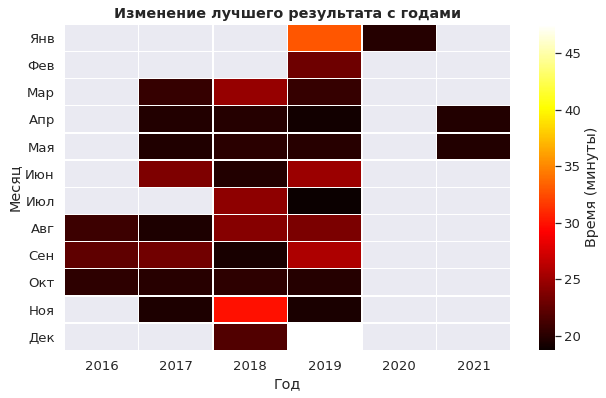

CPU times: user 536 ms, sys: 277 ms, total: 814 ms
Wall time: 883 ms


In [10]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))

# pivot df into long form and aggregate by fastest time
rundata_long = df.pivot_table(index='Месяц', columns='Год', values='t_m', aggfunc=np.min, fill_value=np.nan)
# add rows of zeros for any months missed
for month in months:
    if month not in rundata_long.index.values :
        rundata_long.loc[month] = np.nan
# sort chronological
rundata_long = rundata_long.reindex(months)

sns.heatmap(rundata_long, linewidths=0.4, cmap='hot', cbar_kws={'label': 'Время (минуты)'}, ax=ax)
ax.set_title("Изменение лучшего результата с годами", fontweight='bold')
plt.show()

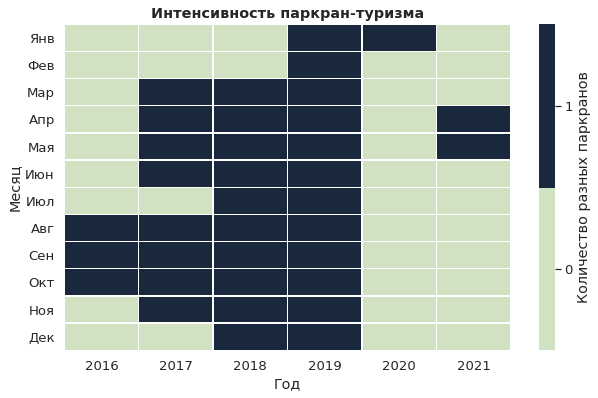

CPU times: user 425 ms, sys: 315 ms, total: 741 ms
Wall time: 783 ms


In [11]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))
aggfun = lambda parkruns: len(np.unique(parkruns, return_counts = True)[1])
# pivot df into long form and aggregate by fastest time
rundata_long = df.pivot_table(index='Месяц', columns='Год', values='Паркран', aggfunc=aggfun, fill_value=0)
maxuniq = rundata_long.max().max()

# add rows of zeros for any months missed
for month in months:
    if month not in rundata_long.index.values :
        rundata_long.loc[month] = np.nan
# sort chronological
rundata_long = rundata_long.reindex(months)
cmap = sns.cubehelix_palette(rot=-.5, n_colors=maxuniq+1)

ticks=np.arange(0, maxuniq+1)
boundaries = np.arange(-0.5, maxuniq+1.5)

sns.heatmap(rundata_long, linewidths=0.4, cmap=cmap, cbar_kws={"ticks":ticks, 'label': 'Количество разных паркранов', "boundaries":boundaries}, ax=ax)
ax.set_title("Интенсивность паркран-туризма", fontweight='bold')
plt.show()

In [12]:
pd.to_datetime(df['Дата parkrun'], dayfirst=True).dt.year

0     2021
1     2021
2     2021
3     2021
4     2021
      ... 
65    2016
66    2016
67    2016
68    2016
69    2016
Name: Дата parkrun, Length: 70, dtype: int64

/media/vol1ura/winC/Users/Юрий/PycharmProjects/notebooks/jupyter/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/media/vol1ura/winC/Users/Юрий/PycharmProjects/notebooks/jupyter/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


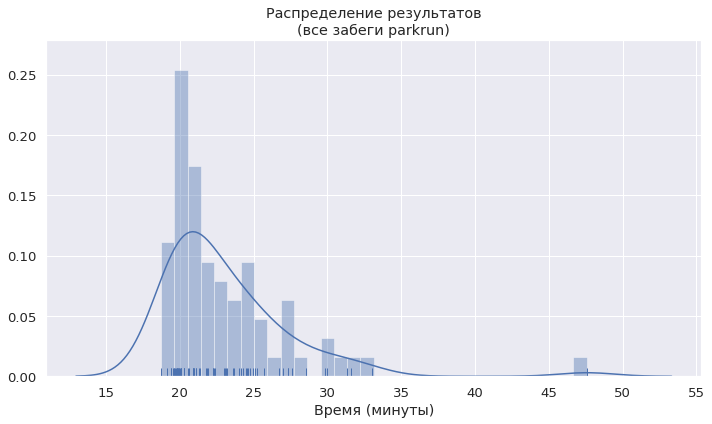

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(df['t_m'], bins=32, rug=True, ax=ax)
ax.set(ylabel='', xlabel='Время (минуты)', title='Распределение результатов\n(все забеги parkrun)')

# ax.invert_yaxis()
plt.tight_layout()

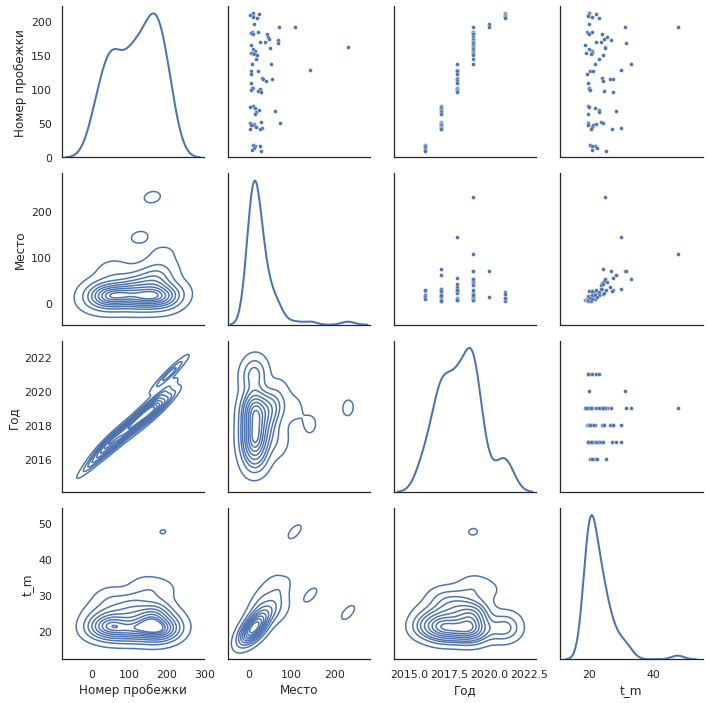

In [14]:
sns.set_theme(style="white")

g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

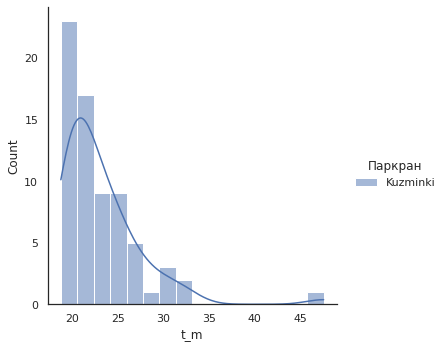

In [15]:
sns.displot(data=df, x='t_m', hue="Паркран", bins=16, kde=True)

<AxesSubplot:xlabel='t_m', ylabel='Паркран'>

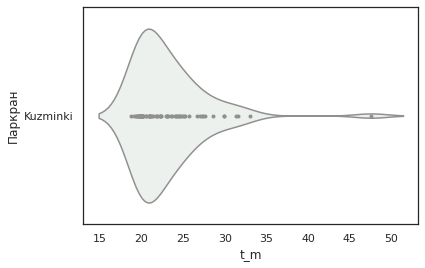

In [16]:
sns.violinplot(data=df, x='t_m', y='Паркран', palette="light:g", inner="points", orient="h")

In [17]:
pos_df = pd.crosstab(df['Паркран'], df['Место'], margins=True)
columns = [1,2,3,'All']
for i in columns:
    if i not in pos_df.columns:
        pos_df[i] = 0
pos_df = pos_df[columns].sort_values(by=columns, ascending=False)
total = pos_df.loc['All']
pos_df.drop('All', axis=0, inplace=True)
pos_df = pos_df.append(total)

In [18]:
separator = '-------------+-----+-----+-----+----'
rows = ['```', 'Паркран/Место|  1  |  2  |  3  | ∑ ', separator]
for row in pos_df.itertuples():
    rows.append(f'{row[0][:12]:<12} | {row[1]:3d} | {row[2]:3d} | {row[3]:3d} | {row[4]:3d}')
rows += [separator, rows.pop().replace('All  ', 'Итого'), '```']
print('\n'.join(rows))

```
Паркран/Место|  1  |  2  |  3  | ∑ 
-------------+-----+-----+-----+----
Kuzminki     |   0 |   0 |   0 |  70
-------------+-----+-----+-----+----
Итого        |   0 |   0 |   0 |  70
```


In [19]:
pos_df

Место,1,2,3,All
Паркран,,,,
Kuzminki,0,0,0,70
All,0,0,0,70


In [20]:
pd.crosstab(df['Паркран'], df['Место'], margins=True)

Место,4,5,6,7,8,9,10,11,12,13,...,52,54,61,69,70,73,107,143,230,All
Паркран,,,,,,,,,,,,,,,,,,,,,
Kuzminki,3,1,6,2,1,3,3,5,2,2,...,1,1,1,2,1,1,1,1,1,70
All,3,1,6,2,1,3,3,5,2,2,...,1,1,1,2,1,1,1,1,1,70
